In [ ]:
#default_exp augmentations

# augmentations

>Implmentation heavily inspired by Ignacio Oguiza - oguiza@gmail.com

In [ ]:
#export
import random
from functools import partial
from scipy.interpolate import CubicSpline
from torchtools.data import *

In [ ]:
#export
import numpy as np
import torch

from fastai2.torch_basics import *
from fastai2.data.all import *

from torchtools.data import *

There are 3 types of noise adding augmentations that can be applied to timeseries data
- scaling: the same noise is a applied to each data point, e.g., each data point is multiplied by a scaling factor f
- jittering: the noise is different for each datapoint, e.g., pick a random scaling factor f_i for each of the data points
- warping: warping is similar to jittering, but the noise is picked from a smooth random curve

These augmentations can be applied to both the y-axis, i.e., the values of the data points, and the x-axis, i.e., the time values of the data points. In case of adding noise to the x-axis of the timeseries data, we usually need to interpolate the corresponding y-value using some kind of piecewise interpolation approach, e.g. CubicSplines

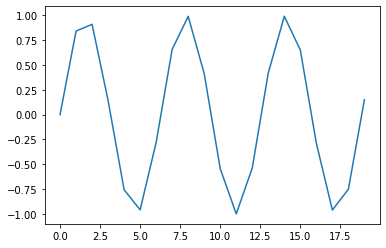

In [ ]:
## set up some sample data
sample_sin = torch.tensor(np.sin(np.arange(20)))[None,:] #one channel
plt.plot(sample_sin[0]);

t = torch.randn((4,20))
ts_tensor = TSTensor(t)

#### Helper Function

Cubic Splines are used for smooth, piecewise interpolation of a sequence of datapoints
- piecewise cubic polynomials
- twice continuously differentiable, i.e. smooth

We use cubic splines both to create random curves for sampling noise for warping and interpolating data points in the case of x-axis noise.

In the example below, we add some noise to our sample data and interpolate the data points with a cubic spline. Since we now have a continuous interpolation of the original data, we can add noise to the x-axis, the interval [0:19] and use the corresponding interpolation values.

In [ ]:
np.arange(10)+np.random.normal(0,0.4, size=10)

array([0.35758828, 1.18687469, 2.13760457, 3.24100066, 4.88711195,
       4.65067893, 5.88387204, 7.00792445, 7.97203506, 9.11759617])

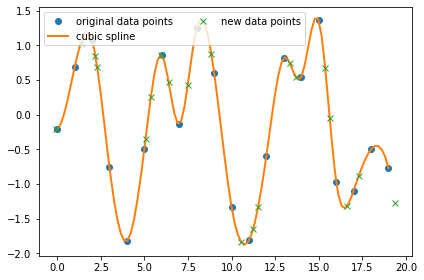

In [ ]:
#hide
rand_noise = np.random.normal(scale=0.5, size=20)
sample_sin = sample_sin+rand_noise
plt.plot(sample_sin[0], 'o', linewidth=1, label='original data points');
cspline = CubicSpline(np.arange(20), sample_sin[0])
plt.plot(np.linspace(0,19, num=100), cspline(np.linspace(0,19, num=100)), linewidth=2, label='cubic spline');
xs_noise = np.arange(20)+np.random.normal(0,0.4, size=20)
plt.plot(xs_noise, cspline(xs_noise), 'x', label='new data points')
plt.legend(loc='upper left', ncol=2)
plt.tight_layout()
plt.show();

In [ ]:
#exports
#oguiza implementation, only used for _magwarp
def random_curve_generator(ts, magnitude=.1, order=4, noise=None):
    '''
    sample points from a gaussian with mean 1 and create a smooth cubic "random curve" from these points
    '''
    seq_len = ts.shape[-1]
    x = np.linspace(-seq_len, 2 * seq_len - 1, 3 * (order - 1) + 1, dtype=int)
    x2 = np.random.normal(loc=1.0, scale=magnitude, size=len(x))
    f = CubicSpline(x, x2, axis=-1)
    return f(np.arange(seq_len))

In [ ]:
#exports

def _create_random_curve(n_channels, seq_len, magnitude, order):
    '''
    create a random curve for each channel in the interval[0, seq_len-1] on order random points
    '''
    x = np.linspace(0, seq_len-1, order)
    y = np.random.normal(loc=1.0, scale=magnitude, size=(n_channels, len(x)))
    f = CubicSpline(x, y, axis=-1)
    return f

def noise_from_random_curve(ts, magnitude=.1, order=4):
    '''
    sample points from a gaussian with mean 1 and create a smooth cubic "random curve" from these points
    ts, needs to be 2D
    order: number of sample to create the random curve from
    '''
    n_channels, seq_len = ts.shape
    f = _create_random_curve(n_channels, seq_len, magnitude, order)
    return f(np.arange(seq_len))

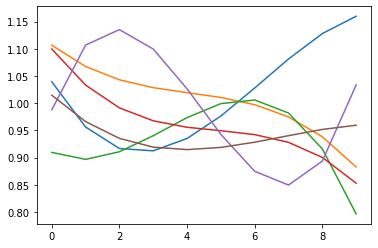

In [ ]:
plt.plot(noise_from_random_curve(torch.randn(6,10)).T);

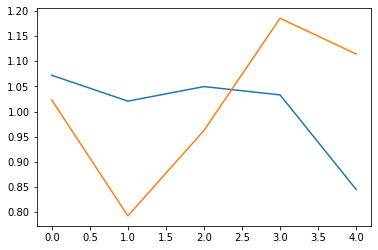

In [ ]:
plt.plot(noise_from_random_curve(torch.tensor([np.arange(5), np.arange(5)]).float()).T);

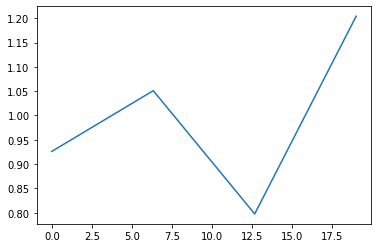

In [ ]:
samples = np.random.normal(loc=1.0, scale=0.1, size=4)
plt.plot(np.linspace(0,19,4), samples);
rcurve = CubicSpline(np.linspace(0,19,4), samples)
# plt.plot(np.linspace(0,19,100), rcurve(samples));

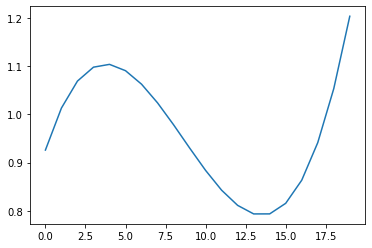

In [ ]:
plt.plot(rcurve(np.arange(20)));

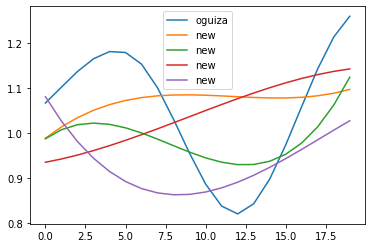

In [ ]:
plt.plot(random_curve_generator(t), label='oguiza')
plt.plot(noise_from_random_curve(t).T, label='new')
plt.legend();

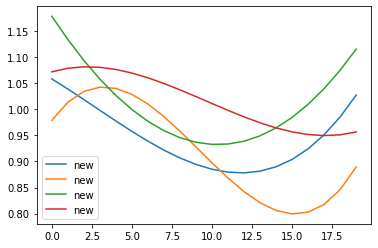

In [ ]:
#multiple channels
plt.plot(noise_from_random_curve(t).T, label='new')
plt.legend();

In [ ]:
#export
def _ynoise(x, magnitude=.1, add=True):
    '''
    add random noise to timeseries values
    '''
#     assert isinstance(x, Tensor)
    if magnitude <= 0: return x
    n_channels, seq_len = x.shape
    noise = torch.normal(0, magnitude, (n_channels, seq_len), dtype=x.dtype, device=x.device)
    if add:
        output = x + noise
        return output
    else:
        output = x * (1 + noise)
        return output 

In [ ]:
t = torch.tensor([np.arange(5), np.arange(5)]).float()
t,_ynoise(t, 0.1), _ynoise(t,0.1,add=False)

(tensor([[0., 1., 2., 3., 4.],
         [0., 1., 2., 3., 4.]]),
 tensor([[0.0506, 1.1226, 1.9749, 3.0051, 4.0099],
         [0.0364, 1.0097, 2.0092, 3.0008, 4.0088]]),
 tensor([[0.0000, 0.9763, 1.9291, 3.1460, 4.2045],
         [0.0000, 0.9332, 1.8629, 2.9696, 4.2809]]))

In [ ]:
#export
def _ywarp(x, magnitude=.1, add=True):
    '''
    add random noise from a curve to timeseries values
    '''
#     assert isinstance(x, Tensor)
    if magnitude <= 0: return x
    n_channels, seq_len = x.shape
    noise = noise_from_random_curve(x)
    print(noise)
    print(x.shape, noise.shape)
    if add:
        output = x + noise
        return output
    else:
        output = x * (1 + noise)
        return output 

In [ ]:
t,_ywarp(t, 0.1), _ywarp(t,0.1,add=False)

[[0.99218995 1.2379953  1.12085783 0.93548532 0.97658552]
 [0.88411864 1.10725016 1.02912283 0.91974147 1.04911092]]
torch.Size([2, 5]) (2, 5)
[[0.96950469 1.25369512 1.18160834 1.00051094 0.95766953]
 [1.03712903 1.06311109 1.05616893 1.005618   0.90077372]]
torch.Size([2, 5]) (2, 5)


(tensor([[0., 1., 2., 3., 4.],
         [0., 1., 2., 3., 4.]]),
 tensor([[0.9922, 2.2380, 3.1209, 3.9355, 4.9766],
         [0.8841, 2.1073, 3.0291, 3.9197, 5.0491]], dtype=torch.float64),
 tensor([[0.0000, 2.2537, 4.3632, 6.0015, 7.8307],
         [0.0000, 2.0631, 4.1123, 6.0169, 7.6031]], dtype=torch.float64))

In [ ]:
def _yscale(x, magnitude=.1, normal=False):
    if magnitude <= 0: return x
    if normal: 
        scale = 1.+(torch.randn(1))*magnitude
    else:
        scale = 1 + torch.rand(1) * magnitude  # uniform [0:1], normal possible
        if np.random.rand() < .5: scale = 1 / scale # scale down
    output = x * scale.to(x.device)
    return output

In [ ]:
t = torch.arange(5)
t,_yscale(t), _yscale(t, normal=True)

(tensor([0, 1, 2, 3, 4]),
 tensor([0.0000, 0.9789, 1.9579, 2.9368, 3.9158]),
 tensor([0.0000, 0.7599, 1.5198, 2.2797, 3.0395]))

#### Distorting the X-axis (Time)

#### Time Warping

In [ ]:
t=torch.rand(1,20)

In [ ]:
noise = noise_from_random_curve(t, magnitude=0.5); noise

array([[0.9483871 , 0.91883216, 0.90123298, 0.89463248, 0.89807355,
        0.91059912, 0.9312521 , 0.9590754 , 0.99311192, 1.03240459,
        1.07599631, 1.12292999, 1.17224855, 1.2229949 , 1.27421195,
        1.32494261, 1.3742298 , 1.42111642, 1.46464539, 1.50385962]])

In [ ]:
## the noise corresponds to time intervals
noise_cum = noise.cumsum(); noise_cum

array([ 0.9483871 ,  1.86721926,  2.76845224,  3.66308472,  4.56115827,
        5.4717574 ,  6.4030095 ,  7.36208489,  8.35519681,  9.3876014 ,
       10.46359771, 11.5865277 , 12.75877625, 13.98177115, 15.2559831 ,
       16.58092572, 17.95515552, 19.37627194, 20.84091733, 22.34477696])

In [ ]:
## we want the first value to be 0 and the last value to be seq_len -1
noise_cum = noise_cum-noise_cum[0]
noise_cum = noise_cum/noise_cum[-1]
noise_cum = noise_cum * (t.shape[1]-1); noise_cum



array([ 0.        ,  0.81592321,  1.61621834,  2.41065222,  3.20814178,
        4.01675405,  4.84370617,  5.69536538,  6.57724904,  7.49402459,
        8.4495096 ,  9.44667174, 10.48762877, 11.57364857, 12.70514913,
       13.88169853, 15.10201497, 16.36396674, 17.66457225, 19.        ])

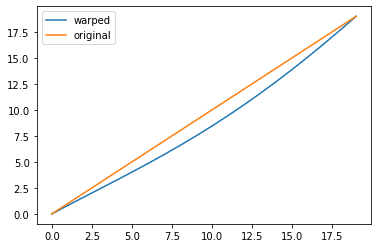

In [ ]:
plt.plot(noise_cum, label='warped')
plt.plot(np.arange(20), label='original')
plt.legend();

In [ ]:
t.shape

torch.Size([2, 5])

In [ ]:
random_cum_curve_generator(t)

array([0.        , 0.92262633, 1.90159201, 2.92695579, 4.        ])

In [ ]:
#x-axis noise, cumulative, oguiza
def random_intervals_from_curve(ts, magnitude=.1, order=4, noise=None):
    '''noise to `[0,..., seq_len]` by sampling deltas from a random curve'''
    noise_cum = noise_from_random_curve(ts, magnitude=magnitude, order=order).cumsum(1)
    noise_cum = noise_cum - np.expand_dims(noise_cum[:,0], -1)
    noise_cum = noise_cum/np.expand_dims(noise_cum[:,-1], -1) * (ts.shape[1]-1)
#     x /= x[-1]
#     x = np.clip(x, 0, 1)
#     print(x)
#     return x * (ts.shape[-1] - 1)
    return noise_cum

In [ ]:
t = torch.rand(2,20)

In [ ]:
random_intervals_from_curve(t)

array([[ 0.        ,  0.97279631,  1.93936054,  2.9052311 ,  3.87497009,
         4.85216331,  5.83942024,  6.83837408,  7.84968171,  8.87302368,
         9.90710428, 10.94965146, 11.99741687, 13.04617586, 14.09072748,
        15.12489446, 16.14152323, 17.13248392, 18.08867034, 19.        ],
       [ 0.        ,  0.93654734,  1.85704197,  2.76987202,  3.68234782,
         4.60070194,  5.53008916,  6.47458649,  7.43719314,  8.41983055,
         9.42334238, 10.44749451, 11.49097503, 12.55139427, 13.62528476,
        14.70810125, 15.79422071, 16.87694235, 17.94848757, 19.        ]])

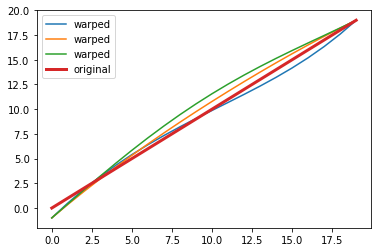

In [ ]:
plt.plot(random_intervals_from_curve(torch.rand(3,20), magnitude=0.3).T, label='warped')
plt.plot(np.arange(20), label='original', linewidth=3)
plt.legend();

In [ ]:
#export
def _timewarp(x, magnitude=.1, order=4):
    '''This is a slow batch tfm on cpu'''
    if magnitude <= 0: return x
    n_channels, seq_len = x.shape
    x_device = x.device ## make sure to put outpout on right device
    x=x.cpu() ## only works on cpu

    
    
    f = CubicSpline(np.arange(seq_len), x, axis=-1)
    plt.plot(x.T)
    plt.plot(np.linspace(0,10), f(np.linspace(0,10)[:, None]).squeeze())
    new_x = random_intervals_from_curve(x, magnitude=magnitude, order=order)
    print (new_x.shape)
    print(new_x)
    print(f(new_x).squeeze(0))
    output = torch.tensor(f(new_x))
    return output.to(x_device)


In [ ]:
np.linspace(0,10)[:,None].shape

(50, 1)

(1, 10)
[[0.         0.98383677 2.0274167  3.10228127 4.18302935 5.2473172
  6.27585847 7.25242418 8.16384276 9.        ]]
[[ 0.          0.83334505  0.8978747   0.03961385 -0.86154665 -0.85954357
  -0.00701087  0.81834359  0.96113433  0.41211849]]


(tensor([[ 0.0000,  0.8415,  0.9093,  0.1411, -0.7568, -0.9589, -0.2794,  0.6570,
           0.9894,  0.4121]]),
 tensor([[[ 0.0000,  0.8333,  0.8979,  0.0396, -0.8615, -0.8595, -0.0070,
            0.8183,  0.9611,  0.4121]]], dtype=torch.float64))

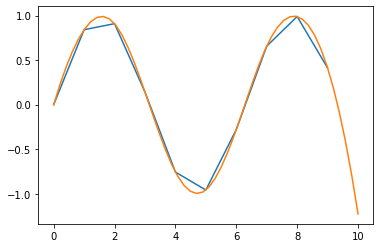

In [ ]:
t = torch.tensor([np.sin(x) for x in range(10)]).unsqueeze(0)
t,_timewarp(t)

(1, 10)
[[0.         0.70148001 1.42563958 2.24004175 3.18205052 4.25883084
  5.44734862 6.69437071 7.91646491 9.        ]]
[[ 0.          0.65989811  0.9794931   0.78514232 -0.03992921 -0.89656734
  -0.74018723  0.40163821  0.99430765  0.41211849]]
tensor([[ 0.0000,  0.6599,  0.9795,  0.7851, -0.0399, -0.8966, -0.7402,  0.4016,
          0.9943,  0.4121]], dtype=torch.float64) tensor([[ 0.0000,  0.8415,  0.9093,  0.1411, -0.7568, -0.9589, -0.2794,  0.6570,
          0.9894,  0.4121]])
(1, 10)
[[0.         1.34779056 2.76988224 4.03113501 5.00709781 5.68400848
  6.15879383 6.6390696  7.44314045 9.        ]]
[[ 0.          0.96559864  0.36260605 -0.77659608 -0.95690535 -0.56248654
  -0.12409353  0.35025423  0.90675846  0.41211849]]


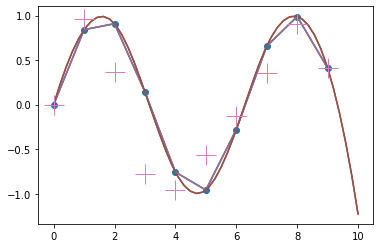

In [ ]:
t = torch.tensor([np.sin(x) for x in range(10)]).unsqueeze(0)
plt.plot(t.T, 'o');
plt.plot(t.T);
print(_timewarp(t, magnitude=0.5).squeeze(0), t)
# plt.plot(_timewarp(t).squeeze(0).T)
plt.plot(_timewarp(t, magnitude=0.5).squeeze(0).T, '+', markersize=20)

In [ ]:
_timewarp(t)

tensor([[[ 0.0000,  0.8977,  0.7720, -0.2471, -0.9764, -0.6173,  0.4135,
           0.9902,  0.5298, -1.2269]]])

In [ ]:
def random_cum_noise_generator(ts, magnitude=.1, noise=None):
    seq_len = ts.shape[-1]
    x = (np.ones(seq_len) + np.random.normal(loc=0, scale=magnitude, size=seq_len)).cumsum()
    x -= x[0]
    x /= x[-1]
    x = np.clip(x, 0, 1)
    return x * (ts.shape[-1] - 1)

In [ ]:
#export
def _timewarp(x, magnitude=.1, order=4):
    '''This is a slow batch tfm on cpu'''
    if magnitude <= 0: return x
    n_channels, seq_len = x.shape
    x_device = x.device ## make sure to put outpout on right device
    x=x.cpu() ## only works on cpu

    f = CubicSpline(np.arange(seq_len), x, axis=-1)
    new_x = random_cum_curve_generator(x, magnitude=magnitude, order=order)
    output = x.new(f(new_x))
    return output.to(x_device) if y is None else [output.to(x_device), y]


In [ ]:
#export
def magwarp(x, magnitude=.1, order=4):
    if magnitude <= 0: return x
    y = None
    if isinstance(x, list):
        y = x[1]
        x = x[0]
    y_mult = random_curve_generator(x, magnitude=magnitude, order=order)
    output = x * x.new(y_mult)
    return output if y is None else [output, y]


In [ ]:
def _timenoise(x, magnitude=.1):
    '''This is a slow batch tfm, requires cpu
    interpolate the timeseries data with a cubic spline, distort time (x-axis) in an additive fashion 
    slightly and replace data by cspline(x_distorted) 
    '''
    if magnitude <= 0: return x
    f = CubicSpline(np.arange(x.shape[-1]), x, axis=-1)
    new_x = random_cum_noise_generator(x, magnitude=magnitude)
    output = x.new(f(new_x))
    return output

In [ ]:
class TimeNoise(Transform):
    order=200
    def encodes(self, x:TSTensor):
        print('timenoise')
        return _timenoise(x.to('cpu')).to(default_device())

In [ ]:
def _timewarp(x, magnitude=.1, order=4):
    '''This is a slow batch tfm'''
    if magnitude <= 0: return x
    y = None
    if isinstance(x, list):
        y = x[1]
        x = x[0]
    seq_len = x.shape[-1]

    f = CubicSpline(np.arange(seq_len), x, axis=-1)
    new_x = random_cum_curve_generator(x, magnitude=magnitude, order=order)
    output = x.new(f(new_x))
    return output if y is None else [output, y]


Cubic Splines are used for smooth, piecewise interpolation of a sequence of datapoints
- piecewise cubic polynomials
- twice continuously differentiable, i.e. smooth

In the following example, we sample 20 datapoints from a sinus function and add a little bit of noise to it. Then we interpolate using a cubic spline.

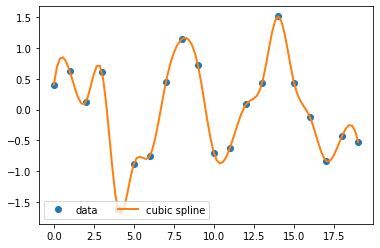

In [ ]:
sample_sin = np.sin(np.arange(20))
rand_noise = np.random.normal(scale=0.5, size=20)
sample_sin = sample_sin+rand_noise
plt.plot(sample_sin, 'o', linewidth=1, label='data');
cspline = CubicSpline(np.arange(20), sample_sin)
plt.plot(np.linspace(0,19, num=100), cspline(np.linspace(0,19, num=100)), linewidth=2, label='cubic spline');
plt.legend(loc='lower left', ncol=2)
plt.show;

In [ ]:
def random_cum_noise_generator(ts, magnitude=.1, noise=None):
    seq_len = ts.shape[-1]
    x = (np.ones(seq_len) + np.random.normal(loc=0, scale=magnitude, size=seq_len)).cumsum()
    x -= x[0]
    x /= x[-1]
    x = np.clip(x, 0, 1)
    return x * (ts.shape[-1] - 1)

In [ ]:
# create some test data
t = torch.randn((4,20))
ts_tensor = TSTensor(t)

In [ ]:
rnd_noise = random_cum_noise_generator(t, magnitude=0.5)
rnd_curve = random_cum_curve_generator(t, magnitude=0.5)

In [ ]:
rnd_noise

array([ 0.        ,  0.29140729,  0.92909616,  1.14366113,  2.06276631,
        2.60308704,  2.73417136,  3.58785065,  4.66503688,  6.3456196 ,
        8.10907795,  9.37617435, 10.42729213, 11.17924775, 12.68556925,
       13.92053676, 15.69081119, 16.6608513 , 17.75705143, 19.        ])

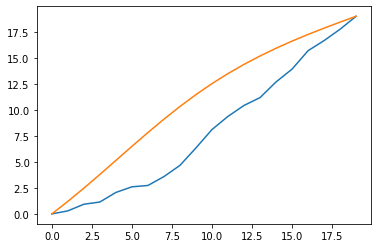

In [ ]:
# plt.plot(np.arange(20))
plt.plot(rnd_noise);
plt.plot(rnd_curve)

In [ ]:
np.random.normal(size=t.shape)

array([[ 0.67517032,  0.54330269,  0.11372752,  0.05964378, -0.56691024,
        -0.03620971, -0.83485444,  0.84663296, -0.84528016, -0.79744924,
        -0.65777784, -0.14120873, -0.19566452,  0.22332193, -1.893933  ,
         0.34546103,  0.19863887,  0.55361131,  0.24453914,  0.23359335],
       [ 0.04796494, -1.91474167,  0.41990336,  0.87159463,  0.92870409,
         0.360661  , -0.84808842,  0.35568726,  1.98277562, -0.31294842,
        -0.7455569 ,  0.69666676, -1.97721147, -0.3018034 ,  2.09157883,
         1.06646163,  1.89632255, -0.58420032, -0.50927886, -0.17475415],
       [ 0.93553452,  0.0190178 ,  0.27566931,  1.58633537, -0.63312677,
         0.21429776, -0.18971262, -1.84071735,  1.4506815 , -1.80987098,
        -0.36692223,  0.90618159, -0.91643275, -1.45871127,  1.08691565,
        -0.34366224, -0.9733597 , -1.22568332,  0.70570418, -0.93344453],
       [ 0.35089811,  0.08640502,  0.17262963,  1.71228651,  1.23550365,
        -0.32666629,  1.37314052,  0.78535326,  

cpu


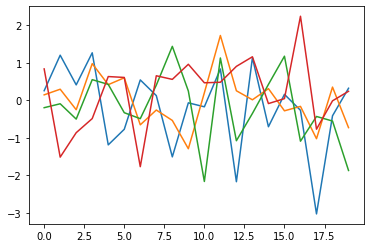

In [ ]:
TSItem(ts_tensor).show()

In [ ]:
ts_tensor.device

device(type='cpu')

In [ ]:
TimeNoise()(ts_tensor)

timenoise


tensor([[ 0.2566,  1.3087,  0.4237,  1.3237, -0.9307, -1.0972,  0.2730,  0.5003,
         -1.3367, -0.1170, -0.2534,  0.9935, -2.1624,  0.7717, -0.4619,  0.0036,
         -0.1603, -3.0298, -0.0249,  0.3222],
        [ 0.1466,  0.4058, -0.2361,  0.8951,  0.4698,  0.6474, -0.3543, -0.4371,
         -0.3305, -1.2955, -0.1251,  1.6859,  0.3333, -0.0479,  0.3344, -0.2508,
         -0.1393, -1.0066,  0.4861, -0.7262],
        [-0.1953, -0.0097, -0.4893,  0.4396,  0.5073, -0.1768, -0.5477,  0.0725,
          1.2815,  0.4194, -2.2035,  0.7969, -0.9728, -0.5717,  0.2993,  1.2590,
         -1.0342, -0.3873, -0.6621, -1.8669],
        [ 0.8373, -1.4792, -0.8492, -0.5577,  0.4812,  0.9468, -1.4472, -0.0572,
          0.6960,  0.9504,  0.5484,  0.4350,  0.8741,  1.2196,  0.0843, -0.1611,
          2.2573, -0.8561,  0.2058,  0.2415]], device='cuda:0')

cpu


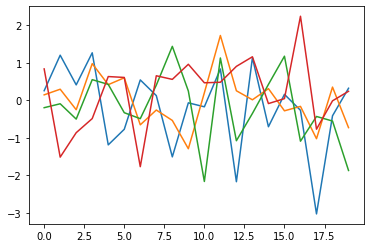

In [ ]:
#cuda
plot_ts(ts_tensor.to('cuda'))

timenoise
TSTensor show
cpu


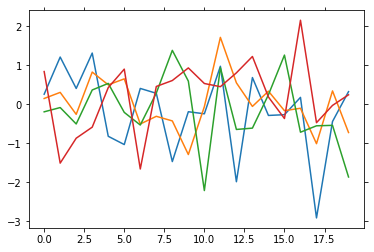

In [ ]:
TimeNoise()(ts_tensor).show()

timenoise
cpu


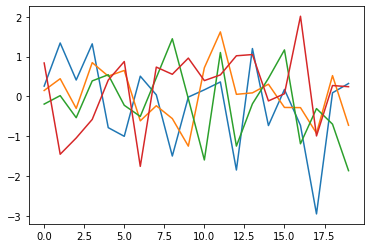

In [ ]:
TSItem(TimeNoise()(ts_tensor)).show()

In [ ]:
# res = timewarp([t.to('cuda'), torch.tensor([0., 0.])])

#### Test NB

In [ ]:
from nbdev.cli import test_nb

In [ ]:
test_nb('./_20_augmentations.ipynb')

CellExecutionError: An error occurred while executing the following cell:
------------------
test_nb('./_20_augmentations.ipynb')
------------------

[0;31m---------------------------------------------------------------------------[0m
[0;31mCellExecutionError[0m                        Traceback (most recent call last)
[0;32m<ipython-input-34-0bd08cbd8e79>[0m in [0;36m<module>[0;34m[0m
[0;32m----> 1[0;31m [0mtest_nb[0m[0;34m([0m[0;34m'./_20_augmentations.ipynb'[0m[0;34m)[0m[0;34m[0m[0;34m[0m[0m
[0m
[0;32m~/anaconda3/envs/nbdev/lib/python3.7/site-packages/nbdev/test.py[0m in [0;36mtest_nb[0;34m(fn, flags)[0m
[1;32m     77[0m         [0mep[0m [0;34m=[0m [0mNoExportPreprocessor[0m[0;34m([0m[0mflags[0m[0;34m,[0m [0mtimeout[0m[0;34m=[0m[0;36m600[0m[0;34m,[0m [0mkernel_name[0m[0;34m=[0m[0;34m'python3'[0m[0;34m)[0m[0;34m[0m[0;34m[0m[0m
[1;32m     78[0m         [0mpnb[0m [0;34m=[0m [0mnbformat[0m[0;34m.[0m[0mfrom_dict[0m[0;34m([0m[0mnb[0m[0;34m)[0m[0;34m[0m[0;34m[0m[0m
[0;32m---> 79[0;31m         [0mep[0m[0;34m.[0m[0mpreprocess[0m[0;34m([0m[0mpnb[0m[0;34m)[0m[0;34m[0m[0;34m[0m[0m
[0m[1;32m     80[0m     [0;32mfinally[0m[0;34m:[0m [0mos[0m[0;34m.[0m[0menviron[0m[0;34m.[0m[0mpop[0m[0;34m([0m[0;34m"IN_TEST"[0m[0;34m)[0m[0;34m[0m[0;34m[0m[0m

[0;32m~/anaconda3/envs/nbdev/lib/python3.7/site-packages/nbconvert/preprocessors/execute.py[0m in [0;36mpreprocess[0;34m(self, nb, resources, km)[0m
[1;32m    403[0m         [0;32mwith[0m [0mself[0m[0;34m.[0m[0msetup_preprocessor[0m[0;34m([0m[0mnb[0m[0;34m,[0m [0mresources[0m[0;34m,[0m [0mkm[0m[0;34m=[0m[0mkm[0m[0;34m)[0m[0;34m:[0m[0;34m[0m[0;34m[0m[0m
[1;32m    404[0m             [0mself[0m[0;34m.[0m[0mlog[0m[0;34m.[0m[0minfo[0m[0;34m([0m[0;34m"Executing notebook with kernel: %s"[0m [0;34m%[0m [0mself[0m[0;34m.[0m[0mkernel_name[0m[0;34m)[0m[0;34m[0m[0;34m[0m[0m
[0;32m--> 405[0;31m             [0mnb[0m[0;34m,[0m [0mresources[0m [0;34m=[0m [0msuper[0m[0;34m([0m[0mExecutePreprocessor[0m[0;34m,[0m [0mself[0m[0;34m)[0m[0;34m.[0m[0mpreprocess[0m[0;34m([0m[0mnb[0m[0;34m,[0m [0mresources[0m[0;34m)[0m[0;34m[0m[0;34m[0m[0m
[0m[1;32m    406[0m             [0minfo_msg[0m [0;34m=[0m [0mself[0m[0;34m.[0m[0m_wait_for_reply[0m[0;34m([0m[0mself[0m[0;34m.[0m[0mkc[0m[0;34m.[0m[0mkernel_info[0m[0;34m([0m[0;34m)[0m[0;34m)[0m[0;34m[0m[0;34m[0m[0m
[1;32m    407[0m             [0mnb[0m[0;34m.[0m[0mmetadata[0m[0;34m[[0m[0;34m'language_info'[0m[0;34m][0m [0;34m=[0m [0minfo_msg[0m[0;34m[[0m[0;34m'content'[0m[0;34m][0m[0;34m[[0m[0;34m'language_info'[0m[0;34m][0m[0;34m[0m[0;34m[0m[0m

[0;32m~/anaconda3/envs/nbdev/lib/python3.7/site-packages/nbconvert/preprocessors/base.py[0m in [0;36mpreprocess[0;34m(self, nb, resources)[0m
[1;32m     67[0m         """
[1;32m     68[0m         [0;32mfor[0m [0mindex[0m[0;34m,[0m [0mcell[0m [0;32min[0m [0menumerate[0m[0;34m([0m[0mnb[0m[0;34m.[0m[0mcells[0m[0;34m)[0m[0;34m:[0m[0;34m[0m[0;34m[0m[0m
[0;32m---> 69[0;31m             [0mnb[0m[0;34m.[0m[0mcells[0m[0;34m[[0m[0mindex[0m[0;34m][0m[0;34m,[0m [0mresources[0m [0;34m=[0m [0mself[0m[0;34m.[0m[0mpreprocess_cell[0m[0;34m([0m[0mcell[0m[0;34m,[0m [0mresources[0m[0;34m,[0m [0mindex[0m[0;34m)[0m[0;34m[0m[0;34m[0m[0m
[0m[1;32m     70[0m         [0;32mreturn[0m [0mnb[0m[0;34m,[0m [0mresources[0m[0;34m[0m[0;34m[0m[0m
[1;32m     71[0m [0;34m[0m[0m

[0;32m~/anaconda3/envs/nbdev/lib/python3.7/site-packages/nbdev/test.py[0m in [0;36mpreprocess_cell[0;34m(self, cell, resources, index)[0m
[1;32m     62[0m         [0;32mfor[0m [0mf[0m [0;32min[0m [0mget_cell_flags[0m[0;34m([0m[0mcell[0m[0;34m)[0m[0;34m:[0m[0;34m[0m[0;34m[0m[0m
[1;32m     63[0m             [0;32mif[0m [0mf[0m [0;32mnot[0m [0;32min[0m [0mself[0m[0;34m.[0m[0mflags[0m[0;34m:[0m  [0;32mreturn[0m [0mcell[0m[0;34m,[0m [0mresources[0m[0;34m[0m[0;34m[0m[0m
[0;32m---> 64[0;31m         [0mres[0m [0;34m=[0m [0msuper[0m[0;34m([0m[0;34m)[0m[0;34m.[0m[0mpreprocess_cell[0m[0;34m([0m[0mcell[0m[0;34m,[0m [0mresources[0m[0;34m,[0m [0mindex[0m[0;34m)[0m[0;34m[0m[0;34m[0m[0m
[0m[1;32m     65[0m         [0;32mreturn[0m [0mres[0m[0;34m[0m[0;34m[0m[0m
[1;32m     66[0m [0;34m[0m[0m

[0;32m~/anaconda3/envs/nbdev/lib/python3.7/site-packages/nbconvert/preprocessors/execute.py[0m in [0;36mpreprocess_cell[0;34m(self, cell, resources, cell_index, store_history)[0m
[1;32m    446[0m             [0;32mfor[0m [0mout[0m [0;32min[0m [0mcell[0m[0;34m.[0m[0moutputs[0m[0;34m:[0m[0;34m[0m[0;34m[0m[0m
[1;32m    447[0m                 [0;32mif[0m [0mout[0m[0;34m.[0m[0moutput_type[0m [0;34m==[0m [0;34m'error'[0m[0;34m:[0m[0;34m[0m[0;34m[0m[0m
[0;32m--> 448[0;31m                     [0;32mraise[0m [0mCellExecutionError[0m[0;34m.[0m[0mfrom_cell_and_msg[0m[0;34m([0m[0mcell[0m[0;34m,[0m [0mout[0m[0;34m)[0m[0;34m[0m[0;34m[0m[0m
[0m[1;32m    449[0m             [0;32mif[0m [0;34m([0m[0mreply[0m [0;32mis[0m [0;32mnot[0m [0;32mNone[0m[0;34m)[0m [0;32mand[0m [0mreply[0m[0;34m[[0m[0;34m'content'[0m[0;34m][0m[0;34m[[0m[0;34m'status'[0m[0;34m][0m [0;34m==[0m [0;34m'error'[0m[0;34m:[0m[0;34m[0m[0;34m[0m[0m
[1;32m    450[0m                 [0;32mraise[0m [0mCellExecutionError[0m[0;34m.[0m[0mfrom_cell_and_msg[0m[0;34m([0m[0mcell[0m[0;34m,[0m [0mreply[0m[0;34m[[0m[0;34m'content'[0m[0;34m][0m[0;34m)[0m[0;34m[0m[0;34m[0m[0m

[0;31mCellExecutionError[0m: An error occurred while executing the following cell:
------------------
TimeNoise()(ts_tensor)
------------------

[0;31m---------------------------------------------------------------------------[0m
[0;31mRuntimeError[0m                              Traceback (most recent call last)
[0;32m<ipython-input-29-5106076f07d2>[0m in [0;36m<module>[0;34m[0m
[0;32m----> 1[0;31m [0mTimeNoise[0m[0;34m([0m[0;34m)[0m[0;34m([0m[0mts_tensor[0m[0;34m)[0m[0;34m[0m[0;34m[0m[0m
[0m
[0;32m~/anaconda3/envs/nbdev/lib/python3.7/site-packages/fastcore/transform.py[0m in [0;36m__call__[0;34m(self, x, **kwargs)[0m
[1;32m     60[0m     [0;34m@[0m[0mproperty[0m[0;34m[0m[0;34m[0m[0m
[1;32m     61[0m     [0;32mdef[0m [0muse_as_item[0m[0;34m([0m[0mself[0m[0;34m)[0m[0;34m:[0m [0;32mreturn[0m [0mifnone[0m[0;34m([0m[0mself[0m[0;34m.[0m[0mas_item_force[0m[0;34m,[0m [0mself[0m[0;34m.[0m[0mas_item[0m[0;34m)[0m[0;34m[0m[0;34m[0m[0m
[0;32m---> 62[0;31m     [0;32mdef[0m [0m__call__[0m[0;34m([0m[0mself[0m[0;34m,[0m [0mx[0m[0;34m,[0m [0;34m**[0m[0mkwargs[0m[0;34m)[0m[0;34m:[0m [0;32mreturn[0m [0mself[0m[0;34m.[0m[0m_call[0m[0;34m([0m[0;34m'encodes'[0m[0;34m,[0m [0mx[0m[0;34m,[0m [0;34m**[0m[0mkwargs[0m[0;34m)[0m[0;34m[0m[0;34m[0m[0m
[0m[1;32m     63[0m     [0;32mdef[0m [0mdecode[0m  [0;34m([0m[0mself[0m[0;34m,[0m [0mx[0m[0;34m,[0m [0;34m**[0m[0mkwargs[0m[0;34m)[0m[0;34m:[0m [0;32mreturn[0m [0mself[0m[0;34m.[0m[0m_call[0m[0;34m([0m[0;34m'decodes'[0m[0;34m,[0m [0mx[0m[0;34m,[0m [0;34m**[0m[0mkwargs[0m[0;34m)[0m[0;34m[0m[0;34m[0m[0m
[1;32m     64[0m     [0;32mdef[0m [0m__repr__[0m[0;34m([0m[0mself[0m[0;34m)[0m[0;34m:[0m [0;32mreturn[0m [0;34mf'{self.__class__.__name__}: {self.use_as_item} {self.encodes} {self.decodes}'[0m[0;34m[0m[0;34m[0m[0m

[0;32m~/anaconda3/envs/nbdev/lib/python3.7/site-packages/fastcore/transform.py[0m in [0;36m_call[0;34m(self, fn, x, split_idx, **kwargs)[0m
[1;32m     71[0m         [0;32mif[0m [0msplit_idx[0m[0;34m!=[0m[0mself[0m[0;34m.[0m[0msplit_idx[0m [0;32mand[0m [0mself[0m[0;34m.[0m[0msplit_idx[0m [0;32mis[0m [0;32mnot[0m [0;32mNone[0m[0;34m:[0m [0;32mreturn[0m [0mx[0m[0;34m[0m[0;34m[0m[0m
[1;32m     72[0m         [0mf[0m [0;34m=[0m [0mgetattr[0m[0;34m([0m[0mself[0m[0;34m,[0m [0mfn[0m[0;34m)[0m[0;34m[0m[0;34m[0m[0m
[0;32m---> 73[0;31m         [0;32mif[0m [0mself[0m[0;34m.[0m[0muse_as_item[0m [0;32mor[0m [0;32mnot[0m [0mis_listy[0m[0;34m([0m[0mx[0m[0;34m)[0m[0;34m:[0m [0;32mreturn[0m [0mself[0m[0;34m.[0m[0m_do_call[0m[0;34m([0m[0mf[0m[0;34m,[0m [0mx[0m[0;34m,[0m [0;34m**[0m[0mkwargs[0m[0;34m)[0m[0;34m[0m[0;34m[0m[0m
[0m[1;32m     74[0m         [0mres[0m [0;34m=[0m [0mtuple[0m[0;34m([0m[0mself[0m[0;34m.[0m[0m_do_call[0m[0;34m([0m[0mf[0m[0;34m,[0m [0mx_[0m[0;34m,[0m [0;34m**[0m[0mkwargs[0m[0;34m)[0m [0;32mfor[0m [0mx_[0m [0;32min[0m [0mx[0m[0;34m)[0m[0;34m[0m[0;34m[0m[0m
[1;32m     75[0m         [0;32mreturn[0m [0mretain_type[0m[0;34m([0m[0mres[0m[0;34m,[0m [0mx[0m[0;34m)[0m[0;34m[0m[0;34m[0m[0m

[0;32m~/anaconda3/envs/nbdev/lib/python3.7/site-packages/fastcore/transform.py[0m in [0;36m_do_call[0;34m(self, f, x, **kwargs)[0m
[1;32m     76[0m [0;34m[0m[0m
[1;32m     77[0m     [0;32mdef[0m [0m_do_call[0m[0;34m([0m[0mself[0m[0;34m,[0m [0mf[0m[0;34m,[0m [0mx[0m[0;34m,[0m [0;34m**[0m[0mkwargs[0m[0;34m)[0m[0;34m:[0m[0;34m[0m[0;34m[0m[0m
[0;32m---> 78[0;31m         [0;32mreturn[0m [0mx[0m [0;32mif[0m [0mf[0m [0;32mis[0m [0;32mNone[0m [0;32melse[0m [0mretain_type[0m[0;34m([0m[0mf[0m[0;34m([0m[0mx[0m[0;34m,[0m [0;34m**[0m[0mkwargs[0m[0;34m)[0m[0;34m,[0m [0mx[0m[0;34m,[0m [0mf[0m[0;34m.[0m[0mreturns_none[0m[0;34m([0m[0mx[0m[0;34m)[0m[0;34m)[0m[0;34m[0m[0;34m[0m[0m
[0m[1;32m     79[0m [0;34m[0m[0m
[1;32m     80[0m [0madd_docs[0m[0;34m([0m[0mTransform[0m[0;34m,[0m [0mdecode[0m[0;34m=[0m[0;34m"Delegate to `decodes` to undo transform"[0m[0;34m,[0m [0msetup[0m[0;34m=[0m[0;34m"Delegate to `setups` to set up transform"[0m[0;34m)[0m[0;34m[0m[0;34m[0m[0m

[0;32m~/anaconda3/envs/nbdev/lib/python3.7/site-packages/fastcore/dispatch.py[0m in [0;36m__call__[0;34m(self, *args, **kwargs)[0m
[1;32m     96[0m         [0;32mif[0m [0;32mnot[0m [0mf[0m[0;34m:[0m [0;32mreturn[0m [0margs[0m[0;34m[[0m[0;36m0[0m[0;34m][0m[0;34m[0m[0;34m[0m[0m
[1;32m     97[0m         [0;32mif[0m [0mself[0m[0;34m.[0m[0minst[0m [0;32mis[0m [0;32mnot[0m [0;32mNone[0m[0;34m:[0m [0mf[0m [0;34m=[0m [0mMethodType[0m[0;34m([0m[0mf[0m[0;34m,[0m [0mself[0m[0;34m.[0m[0minst[0m[0;34m)[0m[0;34m[0m[0;34m[0m[0m
[0;32m---> 98[0;31m         [0;32mreturn[0m [0mf[0m[0;34m([0m[0;34m*[0m[0margs[0m[0;34m,[0m [0;34m**[0m[0mkwargs[0m[0;34m)[0m[0;34m[0m[0;34m[0m[0m
[0m[1;32m     99[0m [0;34m[0m[0m
[1;32m    100[0m     [0;32mdef[0m [0m__get__[0m[0;34m([0m[0mself[0m[0;34m,[0m [0minst[0m[0;34m,[0m [0mowner[0m[0;34m)[0m[0;34m:[0m[0;34m[0m[0;34m[0m[0m

[0;32m<ipython-input-18-1fd5b625263f>[0m in [0;36mencodes[0;34m(self, x)[0m
[1;32m      3[0m     [0;32mdef[0m [0mencodes[0m[0;34m([0m[0mself[0m[0;34m,[0m [0mx[0m[0;34m:[0m[0mTSTensor[0m[0;34m)[0m[0;34m:[0m[0;34m[0m[0;34m[0m[0m
[1;32m      4[0m         [0mprint[0m[0;34m([0m[0;34m'timenoise'[0m[0;34m)[0m[0;34m[0m[0;34m[0m[0m
[0;32m----> 5[0;31m         [0;32mreturn[0m [0m_timenoise[0m[0;34m([0m[0mx[0m[0;34m.[0m[0mto[0m[0;34m([0m[0;34m'cpu'[0m[0;34m)[0m[0;34m)[0m[0;34m.[0m[0mto[0m[0;34m([0m[0mdefault_device[0m[0;34m([0m[0;34m)[0m[0;34m)[0m[0;34m[0m[0;34m[0m[0m
[0m
[0;32m~/coding/python/fastai2/fastai2/torch_core.py[0m in [0;36m_f[0;34m(self, *args, **kwargs)[0m
[1;32m    267[0m         [0;32mdef[0m [0m_f[0m[0;34m([0m[0mself[0m[0;34m,[0m [0;34m*[0m[0margs[0m[0;34m,[0m [0;34m**[0m[0mkwargs[0m[0;34m)[0m[0;34m:[0m[0;34m[0m[0;34m[0m[0m
[1;32m    268[0m             [0mcls[0m [0;34m=[0m [0mself[0m[0;34m.[0m[0m__class__[0m[0;34m[0m[0;34m[0m[0m
[0;32m--> 269[0;31m             [0mres[0m [0;34m=[0m [0mgetattr[0m[0;34m([0m[0msuper[0m[0;34m([0m[0mTensorBase[0m[0;34m,[0m [0mself[0m[0;34m)[0m[0;34m,[0m [0mfn[0m[0;34m)[0m[0;34m([0m[0;34m*[0m[0margs[0m[0;34m,[0m [0;34m**[0m[0mkwargs[0m[0;34m)[0m[0;34m[0m[0;34m[0m[0m
[0m[1;32m    270[0m             [0;32mreturn[0m [0mretain_type[0m[0;34m([0m[0mres[0m[0;34m,[0m [0mself[0m[0;34m)[0m[0;34m[0m[0;34m[0m[0m
[1;32m    271[0m         [0;32mreturn[0m [0m_f[0m[0;34m[0m[0;34m[0m[0m

[0;31mRuntimeError[0m: CUDA error: out of memory
RuntimeError: CUDA error: out of memory

CellExecutionError: An error occurred while executing the following cell:
------------------
TimeNoise()(ts_tensor)
------------------

[0;31m---------------------------------------------------------------------------[0m
[0;31mRuntimeError[0m                              Traceback (most recent call last)
[0;32m<ipython-input-29-5106076f07d2>[0m in [0;36m<module>[0;34m[0m
[0;32m----> 1[0;31m [0mTimeNoise[0m[0;34m([0m[0;34m)[0m[0;34m([0m[0mts_tensor[0m[0;34m)[0m[0;34m[0m[0;34m[0m[0m
[0m
[0;32m~/anaconda3/envs/nbdev/lib/python3.7/site-packages/fastcore/transform.py[0m in [0;36m__call__[0;34m(self, x, **kwargs)[0m
[1;32m     60[0m     [0;34m@[0m[0mproperty[0m[0;34m[0m[0;34m[0m[0m
[1;32m     61[0m     [0;32mdef[0m [0muse_as_item[0m[0;34m([0m[0mself[0m[0;34m)[0m[0;34m:[0m [0;32mreturn[0m [0mifnone[0m[0;34m([0m[0mself[0m[0;34m.[0m[0mas_item_force[0m[0;34m,[0m [0mself[0m[0;34m.[0m[0mas_item[0m[0;34m)[0m[0;34m[0m[0;34m[0m[0m
[0;32m---> 62[0;31m     [0;32mdef[0m [0m__call__[0m[0;34m([0m[0mself[0m[0;34m,[0m [0mx[0m[0;34m,[0m [0;34m**[0m[0mkwargs[0m[0;34m)[0m[0;34m:[0m [0;32mreturn[0m [0mself[0m[0;34m.[0m[0m_call[0m[0;34m([0m[0;34m'encodes'[0m[0;34m,[0m [0mx[0m[0;34m,[0m [0;34m**[0m[0mkwargs[0m[0;34m)[0m[0;34m[0m[0;34m[0m[0m
[0m[1;32m     63[0m     [0;32mdef[0m [0mdecode[0m  [0;34m([0m[0mself[0m[0;34m,[0m [0mx[0m[0;34m,[0m [0;34m**[0m[0mkwargs[0m[0;34m)[0m[0;34m:[0m [0;32mreturn[0m [0mself[0m[0;34m.[0m[0m_call[0m[0;34m([0m[0;34m'decodes'[0m[0;34m,[0m [0mx[0m[0;34m,[0m [0;34m**[0m[0mkwargs[0m[0;34m)[0m[0;34m[0m[0;34m[0m[0m
[1;32m     64[0m     [0;32mdef[0m [0m__repr__[0m[0;34m([0m[0mself[0m[0;34m)[0m[0;34m:[0m [0;32mreturn[0m [0;34mf'{self.__class__.__name__}: {self.use_as_item} {self.encodes} {self.decodes}'[0m[0;34m[0m[0;34m[0m[0m

[0;32m~/anaconda3/envs/nbdev/lib/python3.7/site-packages/fastcore/transform.py[0m in [0;36m_call[0;34m(self, fn, x, split_idx, **kwargs)[0m
[1;32m     71[0m         [0;32mif[0m [0msplit_idx[0m[0;34m!=[0m[0mself[0m[0;34m.[0m[0msplit_idx[0m [0;32mand[0m [0mself[0m[0;34m.[0m[0msplit_idx[0m [0;32mis[0m [0;32mnot[0m [0;32mNone[0m[0;34m:[0m [0;32mreturn[0m [0mx[0m[0;34m[0m[0;34m[0m[0m
[1;32m     72[0m         [0mf[0m [0;34m=[0m [0mgetattr[0m[0;34m([0m[0mself[0m[0;34m,[0m [0mfn[0m[0;34m)[0m[0;34m[0m[0;34m[0m[0m
[0;32m---> 73[0;31m         [0;32mif[0m [0mself[0m[0;34m.[0m[0muse_as_item[0m [0;32mor[0m [0;32mnot[0m [0mis_listy[0m[0;34m([0m[0mx[0m[0;34m)[0m[0;34m:[0m [0;32mreturn[0m [0mself[0m[0;34m.[0m[0m_do_call[0m[0;34m([0m[0mf[0m[0;34m,[0m [0mx[0m[0;34m,[0m [0;34m**[0m[0mkwargs[0m[0;34m)[0m[0;34m[0m[0;34m[0m[0m
[0m[1;32m     74[0m         [0mres[0m [0;34m=[0m [0mtuple[0m[0;34m([0m[0mself[0m[0;34m.[0m[0m_do_call[0m[0;34m([0m[0mf[0m[0;34m,[0m [0mx_[0m[0;34m,[0m [0;34m**[0m[0mkwargs[0m[0;34m)[0m [0;32mfor[0m [0mx_[0m [0;32min[0m [0mx[0m[0;34m)[0m[0;34m[0m[0;34m[0m[0m
[1;32m     75[0m         [0;32mreturn[0m [0mretain_type[0m[0;34m([0m[0mres[0m[0;34m,[0m [0mx[0m[0;34m)[0m[0;34m[0m[0;34m[0m[0m

[0;32m~/anaconda3/envs/nbdev/lib/python3.7/site-packages/fastcore/transform.py[0m in [0;36m_do_call[0;34m(self, f, x, **kwargs)[0m
[1;32m     76[0m [0;34m[0m[0m
[1;32m     77[0m     [0;32mdef[0m [0m_do_call[0m[0;34m([0m[0mself[0m[0;34m,[0m [0mf[0m[0;34m,[0m [0mx[0m[0;34m,[0m [0;34m**[0m[0mkwargs[0m[0;34m)[0m[0;34m:[0m[0;34m[0m[0;34m[0m[0m
[0;32m---> 78[0;31m         [0;32mreturn[0m [0mx[0m [0;32mif[0m [0mf[0m [0;32mis[0m [0;32mNone[0m [0;32melse[0m [0mretain_type[0m[0;34m([0m[0mf[0m[0;34m([0m[0mx[0m[0;34m,[0m [0;34m**[0m[0mkwargs[0m[0;34m)[0m[0;34m,[0m [0mx[0m[0;34m,[0m [0mf[0m[0;34m.[0m[0mreturns_none[0m[0;34m([0m[0mx[0m[0;34m)[0m[0;34m)[0m[0;34m[0m[0;34m[0m[0m
[0m[1;32m     79[0m [0;34m[0m[0m
[1;32m     80[0m [0madd_docs[0m[0;34m([0m[0mTransform[0m[0;34m,[0m [0mdecode[0m[0;34m=[0m[0;34m"Delegate to `decodes` to undo transform"[0m[0;34m,[0m [0msetup[0m[0;34m=[0m[0;34m"Delegate to `setups` to set up transform"[0m[0;34m)[0m[0;34m[0m[0;34m[0m[0m

[0;32m~/anaconda3/envs/nbdev/lib/python3.7/site-packages/fastcore/dispatch.py[0m in [0;36m__call__[0;34m(self, *args, **kwargs)[0m
[1;32m     96[0m         [0;32mif[0m [0;32mnot[0m [0mf[0m[0;34m:[0m [0;32mreturn[0m [0margs[0m[0;34m[[0m[0;36m0[0m[0;34m][0m[0;34m[0m[0;34m[0m[0m
[1;32m     97[0m         [0;32mif[0m [0mself[0m[0;34m.[0m[0minst[0m [0;32mis[0m [0;32mnot[0m [0;32mNone[0m[0;34m:[0m [0mf[0m [0;34m=[0m [0mMethodType[0m[0;34m([0m[0mf[0m[0;34m,[0m [0mself[0m[0;34m.[0m[0minst[0m[0;34m)[0m[0;34m[0m[0;34m[0m[0m
[0;32m---> 98[0;31m         [0;32mreturn[0m [0mf[0m[0;34m([0m[0;34m*[0m[0margs[0m[0;34m,[0m [0;34m**[0m[0mkwargs[0m[0;34m)[0m[0;34m[0m[0;34m[0m[0m
[0m[1;32m     99[0m [0;34m[0m[0m
[1;32m    100[0m     [0;32mdef[0m [0m__get__[0m[0;34m([0m[0mself[0m[0;34m,[0m [0minst[0m[0;34m,[0m [0mowner[0m[0;34m)[0m[0;34m:[0m[0;34m[0m[0;34m[0m[0m

[0;32m<ipython-input-18-1fd5b625263f>[0m in [0;36mencodes[0;34m(self, x)[0m
[1;32m      3[0m     [0;32mdef[0m [0mencodes[0m[0;34m([0m[0mself[0m[0;34m,[0m [0mx[0m[0;34m:[0m[0mTSTensor[0m[0;34m)[0m[0;34m:[0m[0;34m[0m[0;34m[0m[0m
[1;32m      4[0m         [0mprint[0m[0;34m([0m[0;34m'timenoise'[0m[0;34m)[0m[0;34m[0m[0;34m[0m[0m
[0;32m----> 5[0;31m         [0;32mreturn[0m [0m_timenoise[0m[0;34m([0m[0mx[0m[0;34m.[0m[0mto[0m[0;34m([0m[0;34m'cpu'[0m[0;34m)[0m[0;34m)[0m[0;34m.[0m[0mto[0m[0;34m([0m[0mdefault_device[0m[0;34m([0m[0;34m)[0m[0;34m)[0m[0;34m[0m[0;34m[0m[0m
[0m
[0;32m~/coding/python/fastai2/fastai2/torch_core.py[0m in [0;36m_f[0;34m(self, *args, **kwargs)[0m
[1;32m    267[0m         [0;32mdef[0m [0m_f[0m[0;34m([0m[0mself[0m[0;34m,[0m [0;34m*[0m[0margs[0m[0;34m,[0m [0;34m**[0m[0mkwargs[0m[0;34m)[0m[0;34m:[0m[0;34m[0m[0;34m[0m[0m
[1;32m    268[0m             [0mcls[0m [0;34m=[0m [0mself[0m[0;34m.[0m[0m__class__[0m[0;34m[0m[0;34m[0m[0m
[0;32m--> 269[0;31m             [0mres[0m [0;34m=[0m [0mgetattr[0m[0;34m([0m[0msuper[0m[0;34m([0m[0mTensorBase[0m[0;34m,[0m [0mself[0m[0;34m)[0m[0;34m,[0m [0mfn[0m[0;34m)[0m[0;34m([0m[0;34m*[0m[0margs[0m[0;34m,[0m [0;34m**[0m[0mkwargs[0m[0;34m)[0m[0;34m[0m[0;34m[0m[0m
[0m[1;32m    270[0m             [0;32mreturn[0m [0mretain_type[0m[0;34m([0m[0mres[0m[0;34m,[0m [0mself[0m[0;34m)[0m[0;34m[0m[0;34m[0m[0m
[1;32m    271[0m         [0;32mreturn[0m [0m_f[0m[0;34m[0m[0;34m[0m[0m

[0;31mRuntimeError[0m: CUDA error: out of memory
RuntimeError: CUDA error: out of memory

